# 0. Install and Import Dependencies

In [2]:
!pip install opencv-python matplotlib imageio tensorflow

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [4]:
import gdown

In [4]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [5]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [7]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [8]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [9]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [10]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [12]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [13]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [14]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

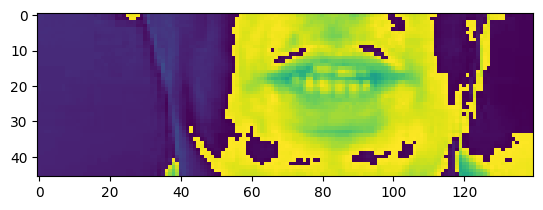

In [15]:
plt.imshow(frames[40])

In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [17]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [18]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [19]:
from matplotlib import pyplot as plt

In [20]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [21]:
len(test)

50

In [22]:
frames, alignments = data.as_numpy_iterator().next()

In [23]:
len(frames)

2

In [24]:
sample = data.as_numpy_iterator()

In [25]:
val = sample.next(); val[0]

array([[[[[1.1987919 ],
          [1.3921453 ],
          [0.8894262 ],
          ...,
          [0.38670704],
          [0.38670704],
          [0.38670704]],

         [[1.430816  ],
          [1.314804  ],
          [0.8120848 ],
          ...,
          [0.38670704],
          [0.38670704],
          [0.38670704]],

         [[1.430816  ],
          [1.5081575 ],
          [1.430816  ],
          ...,
          [0.42537773],
          [0.38670704],
          [0.38670704]],

         ...,

         [[1.1214504 ],
          [1.1214504 ],
          [1.1214504 ],
          ...,
          [0.07734141],
          [0.07734141],
          [0.07734141]],

         [[1.1214504 ],
          [1.1214504 ],
          [1.1214504 ],
          ...,
          [0.07734141],
          [0.07734141],
          [0.07734141]],

         [[1.1214504 ],
          [1.1214504 ],
          [1.1214504 ],
          ...,
          [0.07734141],
          [0.07734141],
          [0.0386707 ]]],


        [[[1.4308

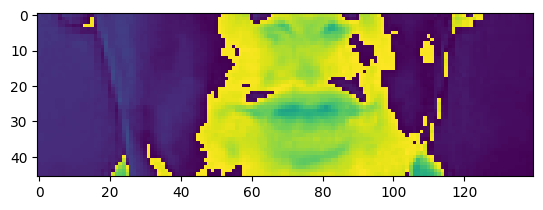

In [26]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [27]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place blue at v four please'>

# 3. Design the Deep Neural Network

In [28]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten, ZeroPadding3D, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [29]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [30]:
model = Sequential()
model.add(ZeroPadding3D(padding=(1, 2, 2), name='zero1', input_shape=(75,46,140,1)))
model.add(Conv3D(32, (3, 5, 5), strides=(1, 2, 2), kernel_initializer='he_normal', name='conv1'))
model.add(BatchNormalization(name='batc1'))
model.add(Activation('relu', name='actv1'))
model.add(SpatialDropout3D(0.5))
model.add(MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max1'))

model.add(ZeroPadding3D(padding=(1, 2, 2), name='zero2'))
model.add(Conv3D(64, (3, 5, 5), strides=(1, 1, 1), kernel_initializer='he_normal', name='conv2'))
model.add(BatchNormalization(name='batc2'))
model.add(Activation('relu', name='actv2'))
model.add(SpatialDropout3D(0.5))
model.add(MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max2'))

model.add(ZeroPadding3D(padding=(1, 1, 1), name='zero3'))
model.add(Conv3D(96, (3, 3, 3), strides=(1, 1, 1), kernel_initializer='he_normal', name='conv3'))
model.add(BatchNormalization(name='batc3'))
model.add(Activation('relu', name='actv3'))
model.add(SpatialDropout3D(0.5))
model.add(MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max3'))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru1'), merge_mode='concat'))

model.add(Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru2'), merge_mode='concat'))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax',))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero1 (ZeroPadding3D)       (None, 77, 50, 144, 1)    0         
                                                                 
 conv1 (Conv3D)              (None, 75, 23, 70, 32)    2432      
                                                                 
 batc1 (BatchNormalization)  (None, 75, 23, 70, 32)    128       
                                                                 
 actv1 (Activation)          (None, 75, 23, 70, 32)    0         
                                                                 
 spatial_dropout3d (SpatialD  (None, 75, 23, 70, 32)   0         
 ropout3D)                                                       
                                                                 
 max1 (MaxPooling3D)         (None, 75, 11, 35, 32)    0         
                                                        

In [32]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [33]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b't6666?66???????666????????????????????????????????t????????????????????????'>

In [34]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b't6666?66???????666????????????????????????????????t????????????????????????'>

In [35]:
model.input_shape

(None, 75, 46, 140, 1)

In [36]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [37]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [38]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [39]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.original_dataset = dataset  # Keep a reference to the original dataset

    def on_epoch_begin(self, epoch, logs=None):
        # Recreate the iterator from the original dataset at the beginning of each epoch
        self.dataset = self.original_dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)


In [40]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [41]:
checkpoint_callback = ModelCheckpoint(os.path.join('model','3dGRUcheckpoint'), monitor='loss', save_weights_only=True) 

In [42]:
schedule_callback = LearningRateScheduler(scheduler)

In [43]:
example_callback = ProduceExample(test)

In [45]:
model.fit(train, validation_data=test, epochs=68, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/68
1/1 [==============================] - 0s 224ms/step loss: 32.51
Original: set blue at a four now
Prediction: sla gre it d foe son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with e six now
Prediction: bla re it s sie goin
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 472s 1s/step - loss: 32.5146 - val_loss: 31.8061 - lr: 7.4082e-05
Epoch 2/68
1/1 [==============================] - 0s 197ms/step loss: 32.39
Original: bin blue with m four now
Prediction: bla wre it g sie nown
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white in m five soon
Prediction: bla bre it g tie agown
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 454s 1s/step - lo

In [ ]:
model.save('models/3dGRUcheckpoint.h5')

# 5. Make a Prediction 

In [82]:
model.load_weights('models\3dGRUcheckpoint.h5')

In [46]:
test_data = test.as_numpy_iterator()

In [47]:
sample = test_data.next()

In [48]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 140ms/step


In [49]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green with t two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white by f five again'>]

In [50]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [51]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'slt gree it z sio please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay ree by c seve again'>]

# Test on a Video

In [52]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [53]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [54]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 249ms/step


In [55]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [56]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin whie it i nine again'>]